In [97]:
from roboflow import Roboflow
import cv2
import numpy as np
from pdf2image import convert_from_path
import PIL
import easyocr
import os
import copy

import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont, Image
rf = Roboflow(api_key="AmMUXsxw896FwSFt1GP7")
project = rf.workspace().project("sinotech")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


# 目標:

### Step1： PDF轉JPG並做預處理

In [107]:
# turn pdf to jpg
path = "../../data/pdf/SheetPile/eval1.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.rotate(img_gray, cv2.ROTATE_90_COUNTERCLOCKWISE)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)

cv2.imwrite("input.jpg", img_blur)

True

### Step2： 用roboflow的模型做section的偵測

In [108]:
# put image to model
result = model.predict(img_blur, confidence=10, overlap=30).json()

#### Visuale the model prediction

In [101]:
model.predict("input.jpg", confidence=10, overlap=30).save("prediction.jpg")

### STEP3：依照模型辨識出的section位置將圖說進行切割

In [109]:
def block_split(result):
    img_left = 80
    img_top = 80
    img_right = 2990
    img_bottom = 2400
    sorted_instance = sorted(result['predictions'], key=lambda k: k['y'])

    section_bbox_list = []
    dummy_y = 0
    temp_section_list = []

    # split the section according to y to represent each row
    for i, instance in enumerate(sorted_instance):
        x, y, w, h= instance['x'], instance['y'], instance['width'], instance['height']
        if y > (dummy_y + 100) and i != 0:
          # sort the temp section list by x and then append temp_section_list to section_bbox_list
          temp_section_list = sorted(temp_section_list, key=lambda k: k[0])
          section_bbox_list.append(copy.deepcopy(temp_section_list))
          # clear temp_section_list
          temp_section_list.clear()
          temp_section_list.append([x, y, w, h])
          dummy_y = y
        else:
          temp_section_list.append([x, y, w, h])
          dummy_y = y

    temp_section_list = sorted(temp_section_list, key=lambda k: k[0])
    section_bbox_list.append(copy.deepcopy(temp_section_list))
          
    # delete temp_section_list and dummy_y
    del temp_section_list
    del dummy_y
    
    # split each section into blocks
    block = []
    for i in range(len(section_bbox_list)):
        for j in range(len(section_bbox_list[i])):
            temp_block = [0,0,0,0]
            # if it is the first block
            if i == 0:
                temp_block[1] = img_top
            else:
                temp_block[1] = section_bbox_list[i-1][j][1] + section_bbox_list[i-1][j][3]/2

            # if it is the last block
            if i == len(section_bbox_list)-1:
                temp_block[3] = img_bottom
            else:
                temp_block[3] = section_bbox_list[i][j][1] + section_bbox_list[i][j][3]/2

            # if it is the left block
            if j == 0:
                temp_block[0] = img_left
            else:
                temp_block[0] = (section_bbox_list[i][j-1][0] + section_bbox_list[i][j][0])/2

            # if it is the right block
            if j == len(section_bbox_list[i])-1:
                temp_block[2] = img_right
            else:
                temp_block[2] = (section_bbox_list[i][j][0] + section_bbox_list[i][j+1][0])/2
            
            block.append(temp_block)

    return block

In [111]:
# generate image according to block
block_images = []
for i, block in enumerate(block_split(result)):
    x, y, w, h = block

    img = img_blur[int(y):int(h), int(x):int(w)]
    block_images.append(img)

#### Visualize the block split

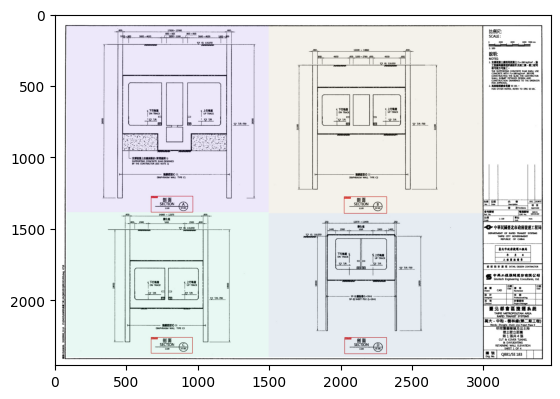

In [110]:
img = cv2.imread("prediction.jpg")
overlay = img.copy()
output = img.copy()
for block in block_split(result):
    # plot dirrenent color for each block
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    # plot the block and  color the area
    cv2.rectangle(overlay, (int(block[0]), int(block[1])), (int(block[2]), int(block[3])), color, -1)
alpha = 0.1
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, output)
cv2.imwrite("block_split.jpg", output)
plt.imshow(output)
plt.show()

### EasyOCR

In [18]:
# setup ocr reader
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [29]:
bounds = reader.readtext(img_blur, detail=1)
array = np.array(img_blur, dtype=object)

In [ ]:
array = np.array(bounds, dtype=object)
print(array)

In [33]:
for w in array:
  print(w[1])

17600 - 15300
Kap:
B00- 601
B00 -600
1020-89
S600
4650
280-320
5600 -4550
SCALE :
IG 416050
Jon
1;100
15300
14860
300 - 2760
4650
@98:
NOTES:
7GL 116050
Kut
RALAtrcazeobt
"fea
TNBRTE
ed01
Ue Supaoring CONCREIE SLAB StVU UsE
CONCREW- f iokolcm
BEFCRI
CONSTRUCIING IE SAB , IE CONIRACTOR
SHALL SudMit_DETAILED DESGN ANd
CONSTRUCIION DRAWNGS T0 #E ENGINEER
FOR APPROVAL
Korh
Bh S 181
FOR OTHER NOIES , REFER TO DRG SE181 .
T6az
Ha4
T6ra
Hoad
DN TRC
UP TRaCK
DN TRACK
UP TRACK
EIR
IIa
LI JR
IIA
EIRZ0
V WR-70
#antbraer(#rrrn
SUPPORING CONCRET SLAB DESGNED
BrTHE CONTRACTOR (SEE NOIE 4
Eaur a
A5EEK Q2-
DAPHRAGM
wa TPE CI
DAPHRAGM WAUL TE Q
am
aw
SECTION
SECTION
Lo
LOO
3Rabb
44860
4.O
@D
1a100
VAR
2300
1270 ~HAOO
5
116050
A40
2300
2300
Loo
#wrecibreiIhA
DEPARTMENT_OFRAPD_TRANST]SYsTBXS
GL 116.0S0
TapB
cy
GOVERNMENT
REPUBUC
0f
CHNA
IttrrrrIaR
T6u
b6ar
4
A
DN TRaOX
UP IRACK
10084#
FIR
IR
EIR70
# 4a DETNL DESKGN CONIRACIOR
##I4ahraMREd
Sinotech Engincering Consultants Ltd
T6rz
16ui
DN TraO
UP TRACK
CA